In [47]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import collections  as mc
#import rioxarray as rxr
import torch


# Opening the MSE-tensors

In [48]:
out1 = torch.load("ConvLSTM1dim_skip_cnn/input4_version1_2features_skip_cnn_0001/savedMseTensors/1.pt")
out2 = torch.load("ConvLSTM1dim_skip_cnn/input4_version1_2features_skip_cnn_0001/savedMseTensors/2.pt")
out3 = torch.load("ConvLSTM1dim_skip_cnn/input4_version1_2features_skip_cnn_0001/savedMseTensors/3.pt")
out4 = torch.load("ConvLSTM1dim_skip_cnn/input4_version1_2features_skip_cnn_0001/savedMseTensors/4.pt")
out5 = torch.load("ConvLSTM1dim_skip_cnn/input4_version1_2features_skip_cnn_0001/savedMseTensors/5.pt")
out6 = torch.load("ConvLSTM1dim_skip_cnn/input4_version1_2features_skip_cnn_0001/savedMseTensors/6.pt")


# Opening a random data-point (satellite image) se we can replace the data inside it with the output-tensor so we still keep the geo-referenced coordinates

In [49]:
file = './data/Data2021/2021_09_01/S_NWC_CMA_MSG4_globeM-VISIR_20210901T000000Z_4dcc7a6a8c7eaf55c00bbb2884fc3057.nc'
files = os.listdir('./data/Data2021/2021_09_01')
rand_file_idx = np.random.randint(97)
rand_file = "./data/Data2021/2021_09_01/" + files[rand_file_idx]

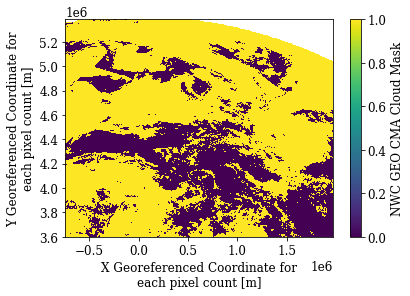

In [50]:
dat =  xr.open_dataset(rand_file, engine="h5netcdf", decode_cf = True)
#dat1 = rxr.open_rasterio(rand_file)
dat.cma.plot()

# Defining Input and output shape

In [51]:
output_area = dat.cma[140+64:396-64,342+64:598-64]
input_area = dat.cma[140:396,342:598]

In [52]:
# Making a copy of the opened satellite image
geo_output1 = output_area.copy()
geo_output2 = output_area.copy()
geo_output3 = output_area.copy()
geo_output4 = output_area.copy()
geo_output5 = output_area.copy()
geo_output6 = output_area.copy()
# replacing the data in the satellite image with the output tensor
geo_output1.data = out1.cpu().squeeze()
geo_output2.data = out2.cpu().squeeze()
geo_output3.data = out3.cpu().squeeze()
geo_output4.data = out4.cpu().squeeze()
geo_output5.data = out5.cpu().squeeze()
geo_output6.data = out6.cpu().squeeze()
# Making a list wit all objects
mse_frames = [geo_output1, geo_output2, geo_output3, geo_output4, geo_output5, geo_output6]

# Creating plot grid

/tmp/ipykernel_3408790/3870670814.py:24: UserWarning: Trying to register the cmap 'rainbow_alpha_mads' which already exists.
  plt.register_cmap(cmap=map_object)


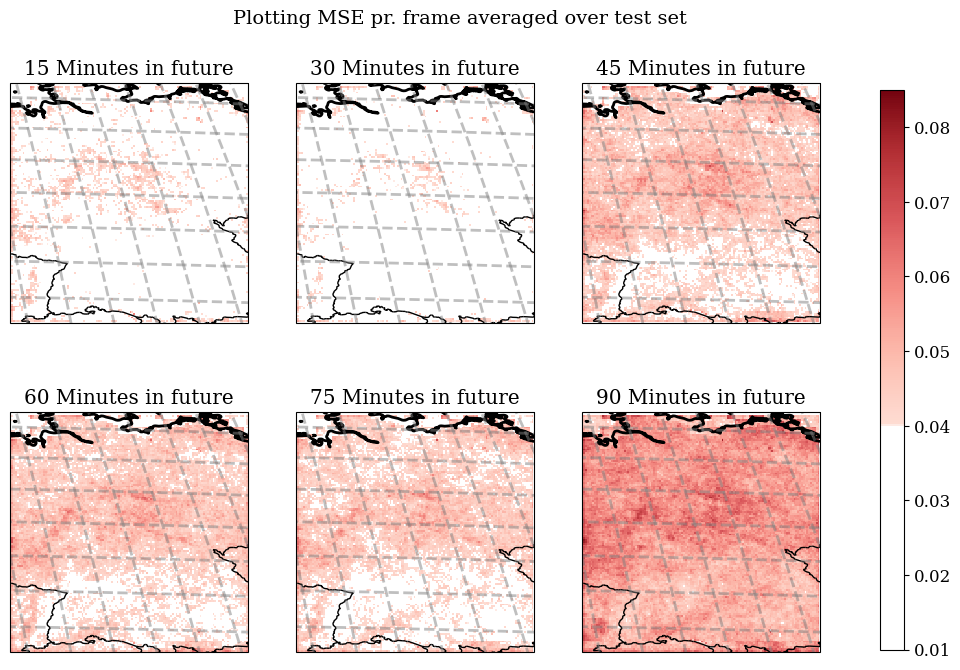

In [53]:
data_proj = ccrs.Geostationary(central_longitude=0, 
    satellite_height=35785863.00, sweep_axis="y", globe=ccrs.Globe())
map_proj = data_proj

plt.rc('font', family='DejaVu serif')
plt.rc('font', size = 12)

# Generating a modified colormap with transparency
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 250
color_array = plt.get_cmap('Reds')(range(ncolors))

# change alpha values
#color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
thr = 100
color_array[0:thr,-1] = 0
color_array[thr:,-1] = np.linspace(0.3,1.0,(ncolors-thr))
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha_mads',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)




fig, axis = plt.subplots(2,3, figsize=(12,8), dpi=100, subplot_kw=dict(projection=map_proj))


for i,ax in enumerate(axis.flatten()):
    #ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
    ax.set_extent([7.83, 12.15, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
    #ax.stock_img()
    im = mse_frames[i].plot(transform = data_proj, cmap='rainbow_alpha_mads', add_colorbar=False, ax = ax, vmin=0.01, vmax = 0.085)
    ax.set_title('{time} Minutes in future'.format(time = (i+1)*15))
    ax.add_feature(cf.COASTLINE, lw=2)
    ax.add_feature(cf.BORDERS)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) #Adjustment from right, adjustment from top, width of CB, height of CB
fig.colorbar(im, cax=cbar_ax)
plt.suptitle("Plotting MSE pr. frame averaged over test set", y=0.95, fontsize = 14) 
plt.savefig("MSEprFrame.pdf")


# Average of error for all frames

In [54]:
avg_error = (torch.cat([out1,out2,out3,out4,out5,out6]).sum(dim=0))/6
geo_avg_error = output_area.copy()
# replacing the data in the satellite image with the output tensor
geo_avg_error.data = avg_error.cpu()


/tmp/ipykernel_3408790/1983045072.py:20: UserWarning: Trying to register the cmap 'mse' which already exists.
  plt.register_cmap(cmap=map_object)


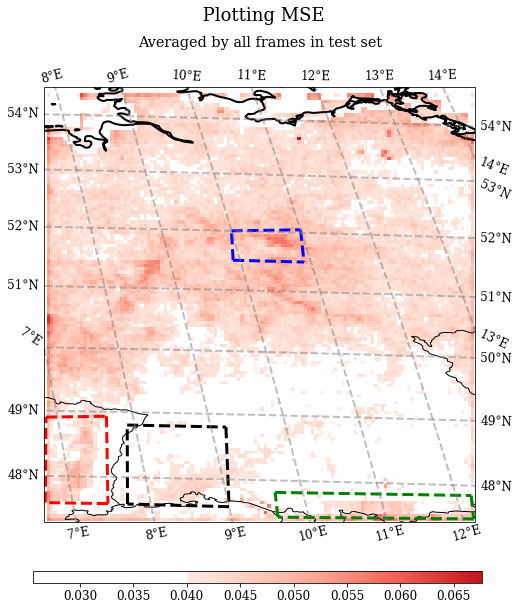

In [55]:
plt.rc('font', family='DejaVu serif')
plt.rc('font', size = 12)

# Generating a modified colormap with transparency
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 200
color_array = plt.get_cmap('Reds')(range(ncolors))

# change alpha values
#color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
thr = 69
color_array[0:thr,-1] = 0
color_array[thr:,-1] = np.linspace(0.3,1.0,(ncolors-thr))
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='mse',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

#Lines to make first box
lines = [[(6.65, 47.6), (6.85, 48.9)], [(6.85, 48.9), (7.65, 48.93)], [(7.65, 48.93), (7.45, 47.6)],[(7.45, 47.6), (6.65, 47.6)]]
lc = mc.LineCollection(lines, linewidths=3, color = "r", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make second box
lines1 = [[(9.9, 51.5), (10, 52)], [(10, 52), (11, 52.05)], [(11, 52.05), (10.9, 51.5)],[(9.9, 51.5), (10.9, 51.5)]]
lc1 = mc.LineCollection(lines1, linewidths=3, color = "blue", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make third box
lines2 = [[(9.6, 47.45), (9.64, 47.82)], [(9.64, 47.82), (12.2, 47.85)], [(12.2, 47.85), (12.14, 47.5)],[(12.14, 47.5), (9.6, 47.45)]]
lc2 = mc.LineCollection(lines2, linewidths=3, color = "g", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make fourth box
lines3 = [[(7.7,47.6), (7.9, 48.8)], [(7.9, 48.8), (9.2, 48.8)], [(9.2, 48.8), (9,47.59)],[(9,47.59), (7.7,47.6)]]
lc3 = mc.LineCollection(lines3, linewidths=3, color = "k", linestyle="--", transform = ccrs.PlateCarree())

fig = plt.figure(figsize=(12,8))
data_proj = ccrs.Geostationary(central_longitude=0, 
    satellite_height=35785863.00, sweep_axis="y", globe=ccrs.Globe())
map_proj = data_proj
ax = plt.axes(projection=map_proj)
#ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
ax.set_extent([7.83, 12.15, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
#ax.stock_img()
#ax.set_extent([4.5, 14.8, 44, 59], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
ax.add_feature(cf.COASTLINE, lw=2)
ax.add_feature(cf.BORDERS)
ax.add_collection(lc)
ax.add_collection(lc1)
ax.add_collection(lc2)
ax.add_collection(lc3)
im = geo_avg_error.plot(transform = data_proj, cmap='mse', add_colorbar = False)
plt.suptitle("     Plotting MSE",y=1.02, fontsize=18)
plt.title("Averaged by all frames in test set", y = 1.08)
plt.scatter(x = 5.278151413236939, y = 58.62858511635695, color="red", s=80, transform = ccrs.PlateCarree()) #Top-left corner
plt.scatter(x = 3.715224194668945, y = 44.285549828485195, color="red", s=80, transform = ccrs.PlateCarree()) # Bottom-left corner
plt.scatter(x = 14.036919170158745, y = 44.52281739161824, color="red", s=80, transform = ccrs.PlateCarree()) # Bottom-right corner
plt.scatter(x = 20.518835840591922, y = 59.28848849319079, color="red", s=80, transform = ccrs.PlateCarree()) # Top-right

#First Box
#plt.scatter(x=6.65, y=47.6, color = "red", s=80, transform = ccrs.PlateCarree()) #Bottom-left
#plt.scatter(x=6.85, y=48.9, color = "red", s=80, transform = ccrs.PlateCarree()) #Top-left
#plt.scatter(x=7.65, y=48.93, color = "red", s=80, transform = ccrs.PlateCarree()) #Top-right
#plt.scatter(x=7.45, y=47.6, color = "red", s=80, transform = ccrs.PlateCarree()) #Bottom-right


#second Box
#plt.scatter(x=9.9, y=51.5, color = "blue", s=80, transform = ccrs.PlateCarree()) #Bottom-left
#plt.scatter(x=10, y=52, color = "blue", s=80, transform = ccrs.PlateCarree()) #Top-left
#plt.scatter(x=11, y=52.05, color = "blue", s=80, transform = ccrs.PlateCarree()) #Top-right
#plt.scatter(x=10.9, y=51.5, color = "blue", s=80, transform = ccrs.PlateCarree()) #Bottom-right

#third Box
#plt.scatter(x=9.6, y=47.45, color = "g", s=80, transform = ccrs.PlateCarree()) #Bottom-left
#plt.scatter(x=9.64, y=47.82, color = "g", s=80, transform = ccrs.PlateCarree()) #Top-left
#plt.scatter(x=12.2, y=47.85, color = "g", s=80, transform = ccrs.PlateCarree()) #Top-right
#plt.scatter(x=12.14, y=47.50, color = "g", s=80, transform = ccrs.PlateCarree()) #Bottom-right

#fourth Box
#plt.scatter(x=7.7, y=47.6, color = "k", s=80, transform = ccrs.PlateCarree()) #Bottom-left
#plt.scatter(x=7.9, y=48.8, color = "k", s=80, transform = ccrs.PlateCarree()) #Top-left
#plt.scatter(x=9.2, y=48.8, color = "k", s=80, transform = ccrs.PlateCarree()) #Top-right
#plt.scatter(x=9, y=47.59, color = "k", s=80, transform = ccrs.PlateCarree()) #Bottom-right


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.25, 0.02, 0.52, 0.02]) #Adjustment from right, adjustment from top, width of CB, height of CB
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')


# Plotting altitude map

/tmp/ipykernel_3408790/3366890452.py:27: UserWarning: Trying to register the cmap 'altitude' which already exists.
  plt.register_cmap(cmap=map_object)


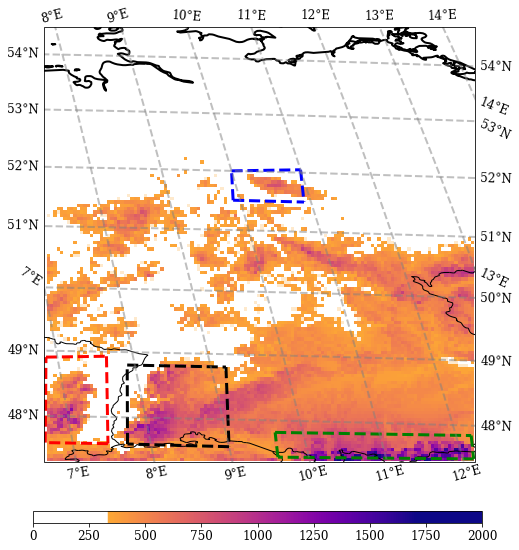

In [56]:
altitude = np.load("MoreData/Altitude.npy")
altitude1 = np.load("data/TestData/Altitude.npy")
np.allclose(altitude,altitude1)

#Input_area used as georeference placeholder
geo_altitude = input_area.copy()
geo_altitude.data = altitude

##########################################################
# Generating a modified colormap with transparency
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 300
color_array = plt.get_cmap('plasma_r')(range(ncolors))

# change alpha values
#color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
#thr = 120
color_array[0:50,-1] = 0
#color_array[105:185,-1] = np.linspace(0.3,1.0,80)
#color_array[215:295,-1] = np.linspace(0.3,1.0,80)
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='altitude',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

#Lines to make box
lines = [[(6.65, 47.6), (6.85, 48.9)], [(6.85, 48.9), (7.65, 48.93)], [(7.65, 48.93), (7.45, 47.6)],[(7.45, 47.6), (6.65, 47.6)]]
lc = mc.LineCollection(lines, linewidths=3, color = "r", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make second box
lines1 = [[(9.9, 51.5), (10, 52)], [(10, 52), (11, 52.05)], [(11, 52.05), (10.9, 51.5)],[(9.9, 51.5), (10.9, 51.5)]]
lc1 = mc.LineCollection(lines1, linewidths=3, color = "blue", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make third box
lines2 = [[(9.6, 47.45), (9.64, 47.82)], [(9.64, 47.82), (12.2, 47.85)], [(12.2, 47.85), (12.14, 47.5)],[(12.14, 47.5), (9.6, 47.45)]]
lc2 = mc.LineCollection(lines2, linewidths=3, color = "g", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make fourth box
lines3 = [[(7.7,47.6), (7.9, 48.8)], [(7.9, 48.8), (9.2, 48.8)], [(9.2, 48.8), (9,47.59)],[(9,47.59), (7.7,47.6)]]
lc3 = mc.LineCollection(lines3, linewidths=3, color = "k", linestyle="--", transform = ccrs.PlateCarree())


fig = plt.figure(figsize=(12,8))
data_proj = ccrs.Geostationary(central_longitude=0, 
    satellite_height=35785863.00, sweep_axis="y", globe=ccrs.Globe())
map_proj = data_proj
ax = plt.axes(projection=map_proj)
#ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
ax.set_extent([7.83, 12.15, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
ax.add_collection(lc)
ax.add_collection(lc1)
ax.add_collection(lc2)
ax.add_collection(lc3)
#ax.stock_img()
#ax.set_extent([4.5, 14.8, 44, 59], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
ax.add_feature(cf.COASTLINE, lw=2)
ax.add_feature(cf.BORDERS)
im = geo_altitude[64:64+128, 64:64+128].plot(transform = data_proj, cmap='altitude', add_colorbar = False, vmin=0, vmax=2000)
plt.scatter(x = 5.278151413236939, y = 58.62858511635695, color="red", s=80, transform = ccrs.PlateCarree()) #Top-left corner
plt.scatter(x = 3.715224194668945, y = 44.285549828485195, color="red", s=80, transform = ccrs.PlateCarree()) # Bottom-left corner
plt.scatter(x = 14.036919170158745, y = 44.52281739161824, color="red", s=80, transform = ccrs.PlateCarree()) # Bottom-right corner
plt.scatter(x = 20.518835840591922, y = 59.28848849319079, color="red", s=80, transform = ccrs.PlateCarree()) # Top-right
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.25, 0.02, 0.52, 0.02]) #Adjustment from right, adjustment from top, width of CB, height of CB
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Creating the plot for paper

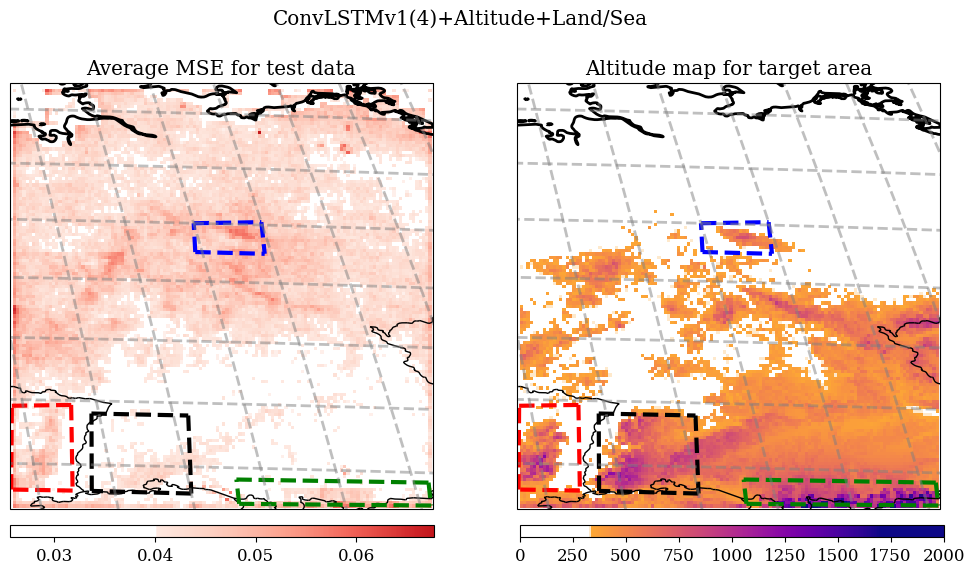

In [57]:
frames = [geo_avg_error, geo_altitude[64:64+128, 64:64+128]]

#Lines to make box mse
lines = [[(6.65, 47.6), (6.85, 48.9)], [(6.85, 48.9), (7.65, 48.93)], [(7.65, 48.93), (7.45, 47.6)],[(7.45, 47.6), (6.65, 47.6)]]
lc_mse = mc.LineCollection(lines, linewidths=3, color = "r", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make second box mse
lines1 = [[(9.9, 51.5), (10, 52)], [(10, 52), (11, 52.05)], [(11, 52.05), (10.9, 51.5)],[(9.9, 51.5), (10.9, 51.5)]]
lc1_mse = mc.LineCollection(lines1, linewidths=3, color = "blue", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make third box mse
lines2 = [[(9.6, 47.45), (9.64, 47.82)], [(9.64, 47.82), (12.2, 47.85)], [(12.2, 47.85), (12.14, 47.5)],[(12.14, 47.5), (9.6, 47.45)]]
lc2_mse = mc.LineCollection(lines2, linewidths=3, color = "g", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make fourth box mse
lines3 = [[(7.7,47.6), (7.9, 48.8)], [(7.9, 48.8), (9.2, 48.8)], [(9.2, 48.8), (9,47.59)],[(9,47.59), (7.7,47.6)]]
lc3_mse = mc.LineCollection(lines3, linewidths=3, color = "k", linestyle="--", transform = ccrs.PlateCarree())


#Lines to make box altitude
lines = [[(6.65, 47.6), (6.85, 48.9)], [(6.85, 48.9), (7.65, 48.93)], [(7.65, 48.93), (7.45, 47.6)],[(7.45, 47.6), (6.65, 47.6)]]
lc_alt = mc.LineCollection(lines, linewidths=3, color = "r", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make second box altitude
lines1 = [[(9.9, 51.5), (10, 52)], [(10, 52), (11, 52.05)], [(11, 52.05), (10.9, 51.5)],[(9.9, 51.5), (10.9, 51.5)]]
lc1_alt = mc.LineCollection(lines1, linewidths=3, color = "blue", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make third box altitude
lines2 = [[(9.6, 47.45), (9.64, 47.82)], [(9.64, 47.82), (12.2, 47.85)], [(12.2, 47.85), (12.14, 47.5)],[(12.14, 47.5), (9.6, 47.45)]]
lc2_alt = mc.LineCollection(lines2, linewidths=3, color = "g", linestyle="--", transform = ccrs.PlateCarree())

#Lines to make fourth box altitude
lines3 = [[(7.7,47.6), (7.9, 48.8)], [(7.9, 48.8), (9.2, 48.8)], [(9.2, 48.8), (9,47.59)],[(9,47.59), (7.7,47.6)]]
lc3_alt = mc.LineCollection(lines3, linewidths=3, color = "k", linestyle="--", transform = ccrs.PlateCarree())




fig, axis = plt.subplots(1,2, figsize=(12,6), dpi=100, subplot_kw=dict(projection=map_proj))

for i,ax in enumerate(axis.flatten()):
    #ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
    ax.set_extent([7.83, 12.15, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
    #ax.stock_img()
    if i == 0:
        im1 = frames[i].plot(transform = data_proj, cmap='mse', add_colorbar=False, ax = ax)
        ax.set_title('Average MSE for test data')
        ax.add_collection(lc_mse)
        ax.add_collection(lc1_mse)
        ax.add_collection(lc2_mse)
        ax.add_collection(lc3_mse)
    else:
        im2 = frames[i].plot(transform = data_proj, cmap='altitude', add_colorbar=False, ax = ax, vmin=0, vmax=2000)
        ax.set_title('Altitude map for target area')
        ax.add_collection(lc_alt)
        ax.add_collection(lc1_alt)
        ax.add_collection(lc2_alt)
        ax.add_collection(lc3_alt)
    ax.add_feature(cf.COASTLINE, lw=2)
    ax.add_feature(cf.BORDERS)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

cbar_ax = fig.add_axes([0.125, 0.1, 0.353, 0.02]) #Adjustment from right, adjustment from top, width of CB, height of CB
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
fig.suptitle("ConvLSTMv1(4)+Altitude+Land/Sea")
cbar_ax2 = fig.add_axes([0.55, 0.1, 0.353, 0.02]) #Adjustment from right, adjustment from top, width of CB, height of CB
fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')
plt.savefig("FeatureArgumentPlot2Features.pdf")


# Geografic split

In [58]:
geo_avg_error.shape

North = geo_avg_error[0:42,]
Middle = geo_avg_error[42:42+42,]
South = geo_avg_error[42+42:,]

#Means
print("North:", np.mean(North))
print("Center:", np.mean(Middle))
print("South:", np.mean(South))

North: <xarray.DataArray 'cma' ()>
array(0.04217383, dtype=float32)
Center: <xarray.DataArray 'cma' ()>
array(0.04422168, dtype=float32)
South: <xarray.DataArray 'cma' ()>
array(0.03872639, dtype=float32)


# Altitude Split

In [59]:
altitude_small = altitude[128:128+128,128:128+128].copy()
np_avg_error=avg_error.cpu().numpy()
# (0-500] split
print("0-500:", np.mean(np_avg_error[np.where(altitude_small <= 500)]))
# (500-1000] split
print("500-1000:", np.mean(np_avg_error[np.where((altitude_small > 500) & (altitude_small <= 1000))]))
# (1000-1500] split
print("1000-1500:", np.mean(np_avg_error[np.where((altitude_small > 1000) & (altitude_small <= 1500))]))
# (1500 - ] split 
print("1000-1500:", np.mean(np_avg_error[np.where(altitude_small > 1500)]))



0-500: 0.041219357
500-1000: 0.042247128
1000-1500: 0.041777458
1000-1500: 0.042019606
